# Image Classification

This code shows how images, specifically vehicle images like cars, trucks, vans, bikes, motorcycles and others, can be classified using Convolutional Neural Network (CNN). This code is built based on an image classifier developed for the "Applied Data Science: Machine Learning" Program from the EPFL Lausanne.
The dataset consists of Swissroads data set which contains several hundreds images of vehicles found in the EPFL - Lausanne area including cars, trucks, vans, bikes, motorcycles and others. The dataset is quite small, hence the results, but could easily be extended to include other datasets and other vehicles classes.

In [1]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# keras imports
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend as K 


import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import math

import cv2
from PIL import Image

# load all images in a directory
from os import listdir
from matplotlib import image

In [2]:
BATCH_SIZE = 16
EPOCHS = 500
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 6
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
LEARNING_RATE = 1e-4

In [3]:
base_dir = os.getcwd()  # Get the current working directory
data_dir = os.path.join(base_dir, 'swissroads')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

In [4]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        if not dir1.endswith(".DS_Store"):

            for file in os.listdir(os.path.join(img_folder, dir1)):
                if file.endswith(".png"):
                    image_path = os.path.join(img_folder, dir1,  file)
                    image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
                    image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
                    image=np.array(image)
                    image = image.astype('float32')
                    image /= 255 
                    img_data_array.append(image)
                    class_name.append(dir1)
    return img_data_array, class_name

In [5]:
# extract the image array and class name
x_train, y_train = create_dataset(train_dir)

In [6]:
# extract the image array and class name
x_val, y_val = create_dataset(valid_dir)

In [7]:
# extract the image array and class name
x_test, y_test = create_dataset(test_dir)

***
**Utility functions**
***

In [8]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [10]:
def plot_accuracy(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['accuracy'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_accuracy'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
  
    plt.legend()

In [11]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [12]:
def cspace_transf(image):
    image = np.array(image)
    return cv2.cvtColor(image,cv2.COLOR_RGB2XYZ)

***
**Using image data augmentation**
***



In [13]:
# apply data augmentation to improve overfitting
train_image_generator = ImageDataGenerator(
                    featurewise_center=True,
                    featurewise_std_normalization=True
) # Generator for our training data

In [14]:
train_image_generator.fit(x_train) 

***
**Standardizing the data**
***

In [16]:
train_image_generator.fit(x_val)

In [17]:
train_image_generator.fit(x_test)

***
**Data pre-processing**
***
In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [18]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = train_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 280 images belonging to 6 classes.


In [19]:
valid_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = valid_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 139 images belonging to 6 classes.


In [20]:
test_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE,
                                                           directory = test_dir,
                                                           shuffle = True,
                                                           target_size = IMG_SIZE,
                                                           class_mode = 'categorical')

Found 50 images belonging to 6 classes.


This part is to check the data format i.e if the RGB channel is coming first or last so that whatever it may be, the model will first check and then get the appropriate input shape be fed accordingly.

In [21]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT) 
else: 
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) 

***
**Build the model**
***

The architectural decisions we will be making are the number of layers, the number of filters, and the size of the filters. In our case we will use a rather small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in the data). 

This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

- **Conv2D** is the layer to convolve the image into multiple images
- **Activation** is the activation function.
- **MaxPooling2D** is used to max pool the value from the given size matrix and same is used for the next 2 layers. then, Flatten is used to flatten the dimensions of the image obtained after convolving it.
- **Dense** is used to make this a fully connected model and is the hidden layer.
- **Dropout** is used to avoid overfitting on the dataset.
- **Dense** is the output layer contains only one neuron which decide to which category image belongs.

Typically the number of layers starts small and grows as the complexity realized by the convoluted layers grows. The number of filters in a layer should be set at ratios of 32, 64, 128, 256, 512 and so on according to one source. In this case I have decided to play a bit with the number of filters and see if smaller values will show improvement.

Filters have odd values since they need to be centered on the pixel being convolved. A 3x3 filter is usual although larger ones of 5x5 up to 7x7 may work better on larger images. Max pool layers typically have a pool size of (2, 2) and are applied after each convolutional layer.

After flattening I use a heavy dropout to prevent overfitting. 

The model was given a single dense layer with activation set to 'relu' as usual. The number of output elements is always set to the number of classes and activation to 'softmax'.

In [22]:
def make_model():
        
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = LEARNING_RATE), metrics=['accuracy'])

    return model

***
**Model Architecture**
***

**Early stopping**

When we’re training a learning algorithm iteratively, we can measure how well each iteration of the model performs. Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data. Early stopping refers stopping the training process before the learner passes that point.

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 30,
    mode = 'max',
    restore_best_weights = True)

In [24]:
callbacks = [early_stopping]

In [25]:
TRAIN_STEPS = int(np.ceil(train_data_gen.n / float(BATCH_SIZE)))

In [26]:
VALIDATION_STEPS = int(np.ceil(valid_data_gen.n / float(BATCH_SIZE)))

In [27]:
TEST_STEPS = int(np.ceil(test_data_gen.n / float(BATCH_SIZE)))

In [28]:
model = make_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        6

***
**Train the model**
***

In [29]:
history = model.fit( 
    train_data_gen, 
    steps_per_epoch = TRAIN_STEPS, 
    epochs = EPOCHS,
#     callbacks = callbacks, 
    validation_data = valid_data_gen, 
    validation_steps = VALIDATION_STEPS) 

Epoch 1/500
18/18 [==============================] - 16s 811ms/step - loss: 3.8785 - accuracy: 0.2152 - val_loss: 17.5309 - val_accuracy: 0.2590
Epoch 2/500
18/18 [==============================] - 18s 982ms/step - loss: 2.2191 - accuracy: 0.4427 - val_loss: 10.1167 - val_accuracy: 0.2590
Epoch 3/500
18/18 [==============================] - 14s 795ms/step - loss: 1.6566 - accuracy: 0.5253 - val_loss: 5.5821 - val_accuracy: 0.2446
Epoch 4/500
18/18 [==============================] - 18s 1s/step - loss: 1.3982 - accuracy: 0.5360 - val_loss: 4.8046 - val_accuracy: 0.2878
Epoch 5/500
18/18 [==============================] - 26s 1s/step - loss: 1.1419 - accuracy: 0.5994 - val_loss: 3.6424 - val_accuracy: 0.3022
Epoch 6/500
18/18 [==============================] - 21s 1s/step - loss: 1.0667 - accuracy: 0.6157 - val_loss: 2.4402 - val_accuracy: 0.3237
Epoch 7/500
18/18 [==============================] - 42s 2s/step - loss: 0.7956 - accuracy: 0.6903 - val_loss: 2.0879 - val_accuracy: 0.3525
Ep

Epoch 59/500
18/18 [==============================] - 22s 1s/step - loss: 0.0576 - accuracy: 0.9774 - val_loss: 2.3826 - val_accuracy: 0.4245
Epoch 60/500
18/18 [==============================] - 22s 1s/step - loss: 0.0543 - accuracy: 0.9706 - val_loss: 2.3870 - val_accuracy: 0.4245
Epoch 61/500
18/18 [==============================] - 22s 1s/step - loss: 0.0232 - accuracy: 0.9935 - val_loss: 2.3812 - val_accuracy: 0.4029
Epoch 62/500
18/18 [==============================] - 22s 1s/step - loss: 0.0586 - accuracy: 0.9853 - val_loss: 2.5169 - val_accuracy: 0.4317
Epoch 63/500
18/18 [==============================] - 23s 1s/step - loss: 0.0762 - accuracy: 0.9520 - val_loss: 2.5982 - val_accuracy: 0.4029
Epoch 64/500
18/18 [==============================] - 22s 1s/step - loss: 0.0437 - accuracy: 0.9820 - val_loss: 2.5442 - val_accuracy: 0.4101
Epoch 65/500
18/18 [==============================] - 22s 1s/step - loss: 0.0409 - accuracy: 0.9839 - val_loss: 2.5435 - val_accuracy: 0.4173
Epoch 

18/18 [==============================] - 19s 1s/step - loss: 0.0221 - accuracy: 0.9964 - val_loss: 2.8637 - val_accuracy: 0.4173
Epoch 174/500
18/18 [==============================] - 19s 1s/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 2.8352 - val_accuracy: 0.4101
Epoch 175/500
18/18 [==============================] - 19s 1s/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 2.8214 - val_accuracy: 0.4388
Epoch 176/500
18/18 [==============================] - 19s 1s/step - loss: 0.0212 - accuracy: 0.9959 - val_loss: 2.8580 - val_accuracy: 0.4460
Epoch 177/500
18/18 [==============================] - 19s 1s/step - loss: 0.0370 - accuracy: 0.9780 - val_loss: 2.7278 - val_accuracy: 0.4388
Epoch 178/500
18/18 [==============================] - 20s 1s/step - loss: 0.0233 - accuracy: 0.9958 - val_loss: 2.6916 - val_accuracy: 0.4388
Epoch 179/500
18/18 [==============================] - 20s 1s/step - loss: 0.0152 - accuracy: 0.9996 - val_loss: 2.8137 - val_accuracy: 0.4388
Epoch 180/500

18/18 [==============================] - 19s 1s/step - loss: 0.0079 - accuracy: 0.9972 - val_loss: 3.8271 - val_accuracy: 0.3885
Epoch 288/500
18/18 [==============================] - 18s 978ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 3.9536 - val_accuracy: 0.3885
Epoch 289/500
18/18 [==============================] - 17s 961ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 3.9611 - val_accuracy: 0.3957
Epoch 290/500
18/18 [==============================] - 18s 975ms/step - loss: 0.0334 - accuracy: 0.9896 - val_loss: 3.3904 - val_accuracy: 0.4173
Epoch 291/500
18/18 [==============================] - 17s 963ms/step - loss: 0.0152 - accuracy: 0.9949 - val_loss: 3.4409 - val_accuracy: 0.3885
Epoch 292/500
18/18 [==============================] - 18s 974ms/step - loss: 0.0178 - accuracy: 0.9918 - val_loss: 3.4041 - val_accuracy: 0.4029
Epoch 293/500
18/18 [==============================] - 18s 972ms/step - loss: 0.0120 - accuracy: 0.9942 - val_loss: 3.4111 - val_accuracy: 0.

18/18 [==============================] - 17s 946ms/step - loss: 0.1127 - accuracy: 0.9832 - val_loss: 5.6014 - val_accuracy: 0.3669
Epoch 400/500
18/18 [==============================] - 17s 952ms/step - loss: 0.0235 - accuracy: 0.9825 - val_loss: 5.3605 - val_accuracy: 0.3813
Epoch 401/500
18/18 [==============================] - 17s 938ms/step - loss: 0.0358 - accuracy: 0.9861 - val_loss: 5.2594 - val_accuracy: 0.4173
Epoch 402/500
18/18 [==============================] - 17s 928ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 5.2328 - val_accuracy: 0.4101
Epoch 403/500
18/18 [==============================] - 17s 921ms/step - loss: 0.0086 - accuracy: 0.9996 - val_loss: 5.2594 - val_accuracy: 0.4101
Epoch 404/500
18/18 [==============================] - 17s 929ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 5.1737 - val_accuracy: 0.3885
Epoch 405/500
18/18 [==============================] - 17s 923ms/step - loss: 0.0101 - accuracy: 0.9952 - val_loss: 5.2861 - val_accuracy:

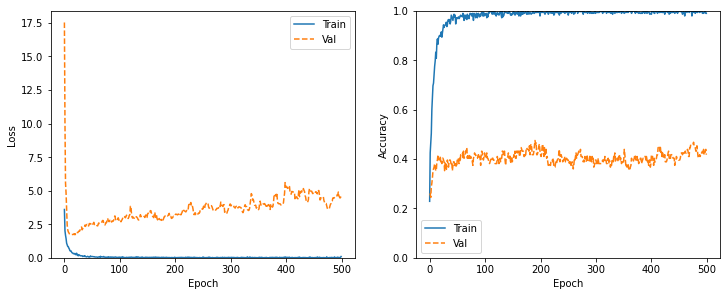

In [30]:
plot_metrics(history)

In [31]:
model.save("cnn_opt_norm_feature.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
# evaluate model on validation data
score = model.evaluate(valid_data_gen, steps = VALIDATION_STEPS, verbose = 2)

9/9 - 2s - loss: 4.6599 - accuracy: 0.4173


In [33]:
print(f'Validation loss: {score[0]} / Validation accuracy: {score[1]}')

Validation loss: 4.659910202026367 / Validation accuracy: 0.41726619005203247


In [34]:
# evaluate model on test data
score = model.evaluate(test_data_gen, steps = TEST_STEPS, verbose = 2)

4/4 - 1s - loss: 3.9206 - accuracy: 0.4800


In [35]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 3.9206342697143555 / Test accuracy: 0.47999998927116394
